In [8]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import json
import ast
from utils import util
import seaborn as sns

The goal of this notebook is to train and test different amino acid-data driven classifiers to determine the specificity of a metal binder to bind it's target. Multiple decision tree based classifiers were used, and ultimately a gradient boosted tree was adopted given it's greater test accuracy.
Data categorical data is all one-hot encoded and in the case where multiple residues are known to coordinate a chosen ion, the model makes predictions independently and can be used to come to a consensus on the binder's specificity from that data.

In [9]:
df_rotamer_pkl = pd.read_pickle('df_rotamer.pkl')

In [10]:
df_rotamer_pkl = df_rotamer_pkl.explode(['bound_residue'])
df_rotamer_pkl.dropna(inplace=True)
#df_rotamer_pkl['encoded_aa']=encoded_residue

In [11]:
x = df_rotamer_pkl.drop(columns=["pdb","metal","ion","motif_binding_xyz","num_NN_atom","NN_atom_properties",'paper_bound_residue','pdb_id'])
x = pd.get_dummies(x,drop_first=True)
y = df_rotamer_pkl["metal"]
y = pd.get_dummies(y,drop_first=True)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.1)

From previously saved data, atomic data is dropped and amino acid data is encoded and split into training and testing data. In cases where multiple residues are coordinating the ion, data is unfurled and retains its original indexing (corresponding to the source protein's identity)

In [12]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
y_pred = dtc.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.5721854304635762


In [13]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
y_pred = rfc.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.5735099337748344


In [15]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
y = df_rotamer_pkl["metal"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.1)
gbc.fit(x_train,y_train)
y_pred = gbc.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.5576158940397351


Classifiers from the sklearn package were run and their test accuracies are reported above. Hyperparameters were not thoroughly optimized due to time constraints. Additionally, a neural network was attempted but was too computationally expensive to train on the data set(i.e. kernel was crashed).
However, test accuracy was acceptably high on the gradient boosted classifier, so it was chosen to move ahead with

<Axes: xlabel='PCA1', ylabel='PCA2'>

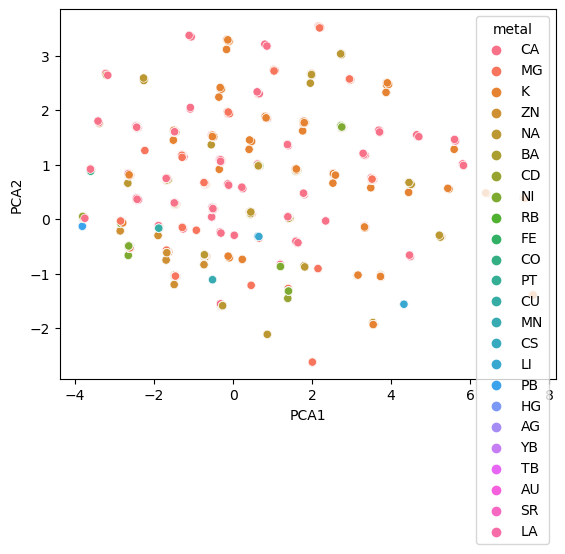

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(x)
df_components = pd.DataFrame(data=components, columns=['PCA1','PCA2'])
metals = df_rotamer_pkl['metal']
metals = metals.reset_index()
PCA_df=pd.concat([df_components,metals],axis=1)
PCA_df
sns.scatterplot(data=PCA_df,x=PCA_df['PCA1'],y=PCA_df['PCA2'],hue=PCA_df['metal'])

#honestly this wasn't that insightful, we can probably remove this if we want to save space

In [17]:
from joblib import dump
dump(gbc,'metal_gradient_clf.joblib')

['metal_gradient_clf.joblib']

This line saves the model and dumps it into a callable file

In [18]:
from joblib import load
gbc = load('metal_gradient_clf.joblib')
x = df_rotamer_pkl.drop(columns=["pdb","metal","ion","motif_binding_xyz","num_NN_atom","NN_atom_properties",'paper_bound_residue','pdb_id'])
x = pd.get_dummies(x,drop_first=True)
y = df_rotamer_pkl["metal"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.1,random_state=42)
gbc.fit(x_train,y_train)
y_pred = gbc.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.6728476821192053


Code to call the model is demonstrated